# Dual Optimal Halpern Method (Dual-OHM) Example

This code tests the Dual Optimal Halpern Method which is another exact optimal method that reduces 
the fixed-point residual $||x - Tx||$ with respect to the initial distance to the solution for 
a nonexpansive operator T. It was introduced in "Optimal acceleration for minimax and fixed-point 
problems is not unique" by TaeHo Yoon, Jaeyeon Kim, Jaewook J. Suh and Ernest K. Ryu (2024).
With the one-to-one correspondence $T = 2J_{A} - I$, the analysis for a nonexpansive T can be 
written solely in terms of a maximally monotone operator $A$.

## Import the required libraries

In [1]:
import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import display

## Define the operators

In [2]:
A = pf.MonotoneOperator(is_basis=True, tags=["A"])

## Write a function to return the PEPContext for Dual-OHM with $T=2J_A - I$

In [3]:
def make_ctx_dual_ohm(ctx_name: str, N: int | sp.Integer) -> pf.PEPContext:
    ctx_dual_ohm = pf.PEPContext(ctx_name).set_as_current()
    y = pf.Vector(is_basis=True, tags=["y_0"])
    A.set_zero_point("y_star")
    Ty_prev = y
    for i in range(N):
        x = A.resolvent(y, sp.S(1), tag=f"x_{i + 1}")
        Ty = 2 * x - y
        y = (
            y + (sp.S(N) - sp.S(i) - sp.S(1)) / (sp.S(N) - sp.S(i)) * (Ty - Ty_prev)
        ).add_tag(f"y_{i + 1}")
        Ty_prev = Ty

    return ctx_dual_ohm

## Numerical evidence on the convergence guarantee for Dual-OHM

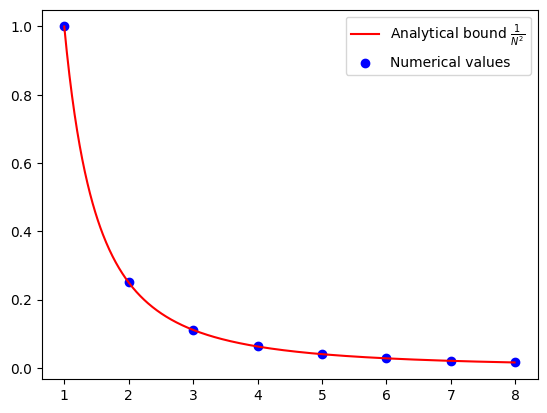

In [4]:
N_max = 8
R = pf.Parameter("R")
R_value = 1

opt_values = []
for N in range(1, N_max + 1):
    ctx_N = make_ctx_dual_ohm(ctx_name=f"ctx_{N}", N=N)
    pb_plt = pf.PEPBuilder(ctx_N)
    pb_plt.add_initial_constraint(
        ((ctx_N["y_0"] - ctx_N["y_star"]) ** 2).le(R, name="initial_condition")
    )
    x_N = ctx_N[f"x_{N}"]
    pb_plt.set_performance_metric(A(x_N) ** 2)
    result = pb_plt.solve(resolve_parameters={"R": R_value})
    opt_values.append(result.opt_value)

iters = np.arange(1, N_max + 1)
cont_iters = np.arange(1, N, 0.01)
plt.plot(
    cont_iters,
    1 / (cont_iters**2),
    "r-",
    label="Analytical bound $\\frac{1}{N^2}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

## Verification of convergence of APPM

In [ ]:
N = sp.S(4)
R_value = sp.S(1)

ctx_prf = make_ctx_dual_ohm(ctx_name="ctx_prf", N=N)
pb_prf = pf.PEPBuilder(ctx_prf)
pb_prf.add_initial_constraint(
    ((ctx_prf["y_0"] - ctx_prf["y_star"]) ** 2).le(R, name="initial_condition")
)
pb_prf.set_performance_metric(A(ctx_prf[f"x_{N}"]) ** 2)

result = pb_prf.solve(resolve_parameters={"R": R_value})
print(result.opt_value)

# Dual variables associated with the interpolations conditions of f with no relaxation
lamb_dense = result.get_scalar_constraint_dual_value_in_numpy(A)

|A(x_4)|^2
0.06249979133182687


In [6]:
pf.launch_primal_interactive(pb_prf, ctx_prf, resolve_parameters={"R": R_value})

Dash app running on http://127.0.0.1:8050/


- It turns out that Dual-OHM would need no further relaxation. Now we store the results.


In [7]:
# Dual variable associated with the initial condition
tau_sol = result.dual_var_manager.dual_value("initial_condition")
# Dual variable associated with the interpolations conditions of A
lamb_sol = result.get_scalar_constraint_dual_value_in_numpy(A)
# Dual variable associated with the Gram matrix G
S_sol = result.get_gram_dual_matrix()

### Verify closed form expression of $\lambda$

In [8]:
def tag_to_index(tag, N=N):
    """This is a function that takes in a tag of an iterate and returns its index.
    We index "x_star" as "N+1 where N is the last iterate.
    """
    # Split the string on "_" and get the index
    if (idx := tag.split("_")[1]).isdigit():
        return int(idx)
    elif idx == "star":
        return N + 1

- Print the values of $\lambda$ obtained from the solver

In [9]:
lamb_sol.pprint()

<IPython.core.display.Math object>

- Consider proper candidate of closed form expression of $\lambda$

In [10]:
def lamb(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if j == N and i < N:
        return sp.S(2) / ((N - i) * (N - i + 1))
    if j == N + 1 and i == N:
        return sp.S(2) / N  ## Between N and optimal
    return 0


lamb_cand = pf.pprint_labeled_matrix(
    lamb, lamb_sol.row_names, lamb_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

- Check whether our candidate of $\lambda$ matches with solution

In [11]:
print(
    "Did we guess the right closed form of lambda?",
    np.allclose(lamb_cand, lamb_sol.matrix, atol=1e-3),
)

Did we guess the right closed form of lambda? True


### Closed form expression of $S$

In [12]:
S_sol.pprint()

<IPython.core.display.Math object>

In [13]:
ctx_prf.basis_vectors()

[y_0, y_star, A(x_1), A(x_2), A(x_3), A(x_4)]

In [14]:
y_0 = ctx_prf["y_0"]
x_N = ctx_prf[f"x_{N}"]
y_star = ctx_prf["y_star"]

S_guess = (A(x_N) - 1 / N * (y_0 - y_star)) ** 2

pm = pf.ExpressionManager(ctx_prf, resolve_parameters={})
S_guess_eval = pm.eval_scalar(S_guess).matrix
pf.pprint_labeled_matrix(S_guess_eval, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [15]:
print(
    "Did we guess the right closed form of S?",
    np.allclose(S_guess_eval, S_sol.matrix, atol=1e-3),
)

Did we guess the right closed form of S? True


#### Verify symbolic calculation for fixed $N$

In [16]:
interpolation_scalar_sum = 0
for i in np.arange(1, N + 2):
    for j in np.arange(1, N + 2):
        xi = "y_star" if i == N + 1 else f"x_{i}"
        xj = "y_star" if j == N + 1 else f"x_{j}"
        if lamb(xi, xj) != 0:
            interpolation_scalar_sum += lamb(xi, xj) * A.interp_ineq(xi, xj)

interpolation_scalar_sum

0+1/6*-(x_1-(x_4))*(A(x_1)-A(x_4))+1/3*-(x_2-(x_4))*(A(x_2)-A(x_4))+1*-(x_3-(x_4))*(A(x_3)-A(x_4))+1/2*-(x_4-y_star)*(A(x_4)-A(y_star))

In [17]:
RHS = interpolation_scalar_sum - S_guess
display(RHS)

0+1/6*-(x_1-(x_4))*(A(x_1)-A(x_4))+1/3*-(x_2-(x_4))*(A(x_2)-A(x_4))+1*-(x_3-(x_4))*(A(x_3)-A(x_4))+1/2*-(x_4-y_star)*(A(x_4)-A(y_star))-|A(x_4)-1/4*(y_0-y_star)|^2

In [18]:
LHS = A(x_N) ** 2 - 1 / (N**2) * (y_0 - y_star) ** 2
display(LHS)

|A(x_4)|^2-1/16*|y_0-y_star|^2

In [19]:
difference = LHS - RHS
display(difference)

|A(x_4)|^2-1/16*|y_0-y_star|^2-(0+1/6*-(x_1-(x_4))*(A(x_1)-A(x_4))+1/3*-(x_2-(x_4))*(A(x_2)-A(x_4))+1*-(x_3-(x_4))*(A(x_3)-A(x_4))+1/2*-(x_4-y_star)*(A(x_4)-A(y_star))-|A(x_4)-1/4*(y_0-y_star)|^2)

In [ ]:
pf.pprint_str(difference.repr_by_basis(ctx_prf, sympy_mode=True))

<IPython.core.display.Math object>

: 

\begin{align*}
    \| \tilde{\mathbb{A}}(x^N) \|^2 - \frac{\| x^0 - x^\star \|^2}{N^2}
    &= -\sum_{k=1}^{N-1} \frac{2}{(N-k)(N-k+1)} \langle \tilde{\mathbb{A}}(x^N) - \tilde{\mathbb{A}}(x^k), x^N - x^k \rangle \\&\quad 
    - \frac{2}{N} \langle \tilde{\mathbb{A}}(x^{N}), x^{N} - x^\star \rangle \\&\quad 
    - \| \tilde{\mathbb{A}}(x^N) - \frac{1}{N} ( x^0 - x^\star)  \| ^2.
\end{align*}